In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import os
import random

def IC50_to_pIC50(ic50_nM):
    if pd.isna(ic50_nM):
        return np.nan
    return 9 - np.log10(ic50_nM)

def pIC50_to_IC50(pIC50):
    if pd.isna(pIC50):
        return np.nan
    return 10 ** (9 - pIC50)

In [3]:
# 데이터 로드

raw_data_path = "../data/250708_raw/"

cas = pd.read_excel(raw_data_path + "CAS_KPBMA_MAP3K5_IC50s.xlsx", sheet_name="MAP3K5 Ligand IC50s", header=1)
chembl = pd.read_csv(raw_data_path + "ChEMBL_ASK1(IC50).csv", sep=";")
pubchem = pd.read_csv(raw_data_path + "Pubchem_ASK1.csv")

/tmp/ipykernel_2953143/2744802953.py:7: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  pubchem = pd.read_csv(raw_data_path + "Pubchem_ASK1.csv")


문헌조사 결과, activity value의 단위는
- chembl: nM
- PubChem: nM이 아닌 uM
- CAS: uM

인 것으로 보임

Activity value 최댓값: 500000.0 nM


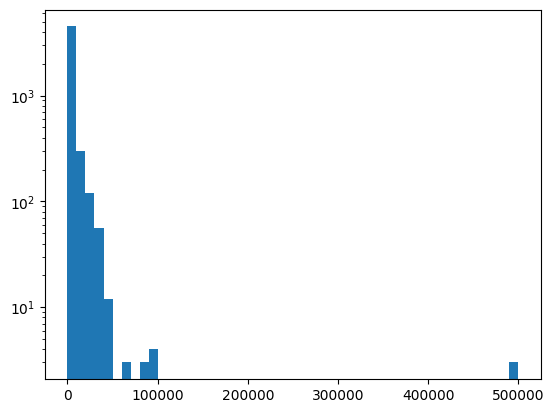

In [ ]:
# not active data의 labeling을 위해서 active data(nM) 최댓값 확인 -> 500000nM

values = np.concat(
    [
    chembl["Standard Value"].values,
    pubchem["Activity_Value"].values * 1000,
    cas["Single Value (Parsed)"].values * 1000
    ]
)

print(f"Activity value 최댓값: {values[~np.isnan(values)].max()} nM")

plt.hist(values, bins=50)
plt.yscale('log')
plt.show()

In [13]:
# SMILES 없는 데이터 제거

cas = cas.dropna(subset="SMILES")
chembl = chembl.dropna(subset="Smiles")
pubchem = pubchem.dropna(subset="SMILES")

IC50 값이 범위로 표현되는 경우, IC50이 logarithmic scale을 따르므로 상/하한값 사이의 geometric averge 적용


In [21]:
# cas 처리
def process_cas(row, imputation=False):
    def calc_geom_mean(a, b):
        return np.sqrt(a*b)
    
    display = row["Display Measurement"]
    single = row["Single Value (Parsed)"]
    low = row["Low-End Value (Parsed)"]
    high = row["High-End Value (Parsed)"]
    
    ic50_nM = np.nan
    if display == "not active" and imputation:
        ic50_nM = 500000
    elif not pd.isna(single) and pd.isna(low) and pd.isna(high): # single value가 있고, 범위값이 아닐 때
        ic50_nM = single * 1000
    elif not pd.isna(low) and not pd.isna(high): # single value가 없고, 범위값으로 주어졌을 때
        ic50_nM = calc_geom_mean(low, high) * 1000
    
    return ic50_nM

cleaned_cas = pd.DataFrame()

cleaned_cas['smiles'] = cas['SMILES']
cleaned_cas['ic50_nm'] = cas.apply(process_cas, imputation=False, axis=1)
cleaned_cas['ic50_nm_imputed'] = cas.apply(process_cas, imputation=True, axis=1)
cleaned_cas['is_active(10um)'] = cleaned_cas['ic50_nm_imputed'].apply(lambda x: True if x < 10000 else False)
cleaned_cas['data_source'] = "CAS"
cleaned_cas['data_id'] = cas["Substance Name"]

cleaned_cas.head()

,smiles,ic50_nm,ic50_nm_imputed,is_active(10um),data_source,data_id
0,O[C@H]1[C@H](N2C=3C(N=C2)=C(N)N=CN3)O[C@H](COP...,2433.33,2433.33,True,CAS,5′-ATP
1,S(C)C1=C2C(=NC(N)=N1)N=CN2,13300.00,13300.00,False,CAS,6-Methylthioguanine
2,N(C1=C2C(N=CN2)=NC=N1)C3=CC=CC=C3,10000.00,10000.00,False,CAS,N-Phenyl-9H-purin-6-amine
3,C12=C(N=CN=C1N=CN2)N3CCCCC3,17000.00,17000.00,False,CAS,6-(1-Piperidinyl)-9H-purine
4,C(C)(=O)C1=C2C=3C(C(=O)C=4C2=CC=CC4)=CC=CC3NC1=O,15000.00,15000.00,False,CAS,"1-Acetyl-3H-naphtho[1,2,3-de]quinoline-2,7-dione"


In [22]:
# chembl 처리
def process_chembl(row, imputation=False):
    ic50_nm = row["Standard Value"]
    if pd.isna(ic50_nm):
        if imputation:
            ic50_nm = 500000
        else:
            ic50_nm = np.nan
    return ic50_nm
    
cleaned_chembl = pd.DataFrame()

cleaned_chembl["smiles"] = chembl["Smiles"]
cleaned_chembl["ic50_nm"] = chembl.apply(process_chembl, imputation=False, axis=1)
cleaned_chembl["ic50_nm_imputed"] = chembl.apply(process_chembl, imputation=True, axis=1)
cleaned_chembl["is_active(10um)"] = cleaned_chembl["ic50_nm_imputed"].apply(lambda x: True if x < 10000 else False)
cleaned_chembl["data_source"] = "CHEMBL"
cleaned_chembl["data_id"] = chembl["Molecule ChEMBL ID"]

cleaned_chembl.head()

,smiles,ic50_nm,ic50_nm_imputed,is_active(10um),data_source,data_id
0,Cn1cc(Cl)c2cnc(NC(=O)c3ccc([C@](C)(O)CO)cc3)cc21,38.0,38.0,True,CHEMBL,CHEMBL3927617
1,Cc1cc2c(-c3ccc(S(=O)(=O)NCCN)s3)ccnc2[nH]1,251.0,251.0,True,CHEMBL,CHEMBL3330172
2,Cc1cc(C)c2nc(N3C(=O)C(O)=C(C(=O)c4ccc(Cl)cc4)C...,6300.0,6300.0,True,CHEMBL,CHEMBL3402498
3,Cc1ccc(C(=O)C2=C(O)C(=O)N(c3nc4ccc(F)cc4s3)C2c...,7600.0,7600.0,True,CHEMBL,CHEMBL3402495
4,CCOc1ccc2nc(N3C(=O)C(O)=C(C(=O)c4ccccc4)C3c3cc...,4200.0,4200.0,True,CHEMBL,CHEMBL3402491


In [23]:
# pubchem 처리
def process_pubchem(row, imputation=False):
    activity_value = row["Activity_Value"]
    activity = row["Activity"]
    
    if not pd.isna(activity_value):
        ic50_nm = activity_value * 1000
    else:
        ic50_nm = np.nan
        
    if pd.isna(ic50_nm) and imputation:
        if activity == "Active":
            ic50_nm = 100 # weakly active
        elif activity == "Inactive":
            ic50_nm = 500000
        else: # inconclusive, unspecified
            ic50_nm = 10000
    
    return ic50_nm

def check_pubchem_activity(row):
    activity_value = row["Activity_Value"]
    activity = row['Activity']
    
    if activity == "Active":
        return True
    elif activity == "Inactive":
        return False
    else: # inconclusive or unspecified:
        if pd.notna(activity_value):
            return True if activity_value < 10 else False
        else:
            return np.nan
        
cleaned_pubchem = pd.DataFrame()

cleaned_pubchem["smiles"] = pubchem["SMILES"]
cleaned_pubchem["ic50_nm"] = pubchem.apply(process_pubchem, imputation=False, axis=1)
cleaned_pubchem["ic50_nm_imputed"] = pubchem.apply(process_pubchem, imputation=True, axis=1)
cleaned_pubchem["is_active(10um)"] = pubchem.apply(check_pubchem_activity, axis=1)
cleaned_pubchem["data_source"] = "PUBCHEM"
cleaned_pubchem["data_id"] = pubchem["Compound_CID"]

cleaned_pubchem.head()

,smiles,ic50_nm,ic50_nm_imputed,is_active(10um),data_source,data_id
0,CC1=CC(=C(C=C1S(=O)(=O)N)C(=O)NC2=CC=CC(=N2)C3...,0.10,0.10,True,PUBCHEM,145990765
1,CCS(=O)(=O)NC1=CC(=C(C=C1)OC)C(=O)NC2=CC=CC(=N...,0.32,0.32,True,PUBCHEM,145989111
2,CNC(=O)C1CCN(CC1)C2=CN=C(C=C2N3C=C(N=C3)C4CC4)...,0.40,0.40,True,PUBCHEM,91810341
3,CC1=CC(=C(C=C1C(=O)N)C(=O)NC2=CC=CC(=N2)C3=NN=...,0.42,0.42,True,PUBCHEM,145994100
4,CC12C(C(CC(O1)N3C4=CC=CC=C4C5=C6C(=C7C8=CC=CC=...,0.69,0.69,True,PUBCHEM,44259


In [24]:
combined = pd.concat([cleaned_cas, cleaned_chembl, cleaned_pubchem])
combined.head()

,smiles,ic50_nm,ic50_nm_imputed,is_active(10um),data_source,data_id
0,O[C@H]1[C@H](N2C=3C(N=C2)=C(N)N=CN3)O[C@H](COP...,2433.33,2433.33,True,CAS,5′-ATP
1,S(C)C1=C2C(=NC(N)=N1)N=CN2,13300.00,13300.00,False,CAS,6-Methylthioguanine
2,N(C1=C2C(N=CN2)=NC=N1)C3=CC=CC=C3,10000.00,10000.00,False,CAS,N-Phenyl-9H-purin-6-amine
3,C12=C(N=CN=C1N=CN2)N3CCCCC3,17000.00,17000.00,False,CAS,6-(1-Piperidinyl)-9H-purine
4,C(C)(=O)C1=C2C=3C(C(=O)C=4C2=CC=CC4)=CC=CC3NC1=O,15000.00,15000.00,False,CAS,"1-Acetyl-3H-naphtho[1,2,3-de]quinoline-2,7-dione"


In [ ]:
# 중복된 SMILES에 대해 IC50 값들을 평균 처리
def calc_geom_mean_safe(values) -> float:
    # nan, 음수 제거
    clean_values = values.dropna()
    clean_values = clean_values[clean_values > 0]

    if len(clean_values) == 0:
        return np.nan
    elif len(clean_values) == 1:
        return clean_values.iloc[0]
    else:
        return np.exp(np.log(clean_values).mean()) # geometric mean

combined_dedup = combined.groupby('smiles').agg({
    'ic50_nm': calc_geom_mean_safe,
    'ic50_nm_imputed': calc_geom_mean_safe, 
    'is_active(10um)': lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else x.iloc[0],
    'data_source': lambda x: ', '.join(x.unique()),
    'data_id': lambda x: ', '.join(x.astype(str).unique())
}).reset_index()


,smiles,ic50_nm,ic50_nm_imputed,is_active(10um),data_source,data_id


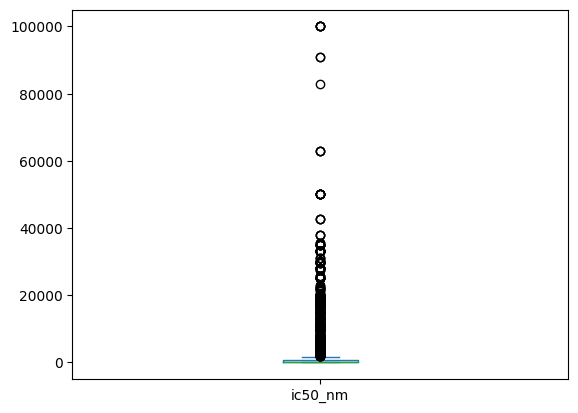

In [39]:
# ic50_nm 분포 확인
combined_dedup['ic50_nm'].plot(kind="box") # 500000 은 이상치로 보임
combined_dedup[combined_dedup['ic50_nm'] > 100000]

In [40]:
# 최대치는 100000으로 thresholding하겠습니다.
combined_dedup['ic50_nm'] = combined_dedup['ic50_nm'].apply(lambda x: 100000 if x > 100000 else x)
combined_dedup['ic50_nm_imputed'] = combined_dedup['ic50_nm_imputed'].apply(lambda x: 100000 if x > 100000 else x)

In [41]:
# pIC50 변환
combined_dedup['pvalue'] = combined_dedup['ic50_nm'].apply(IC50_to_pIC50)
combined_dedup['pvalue_imputed'] = combined_dedup['ic50_nm_imputed'].apply(IC50_to_pIC50)

In [42]:
# rdkit mol 객체화
def smiles2mol(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        mol = Chem.MolFromSmiles(smiles, sanitize=False)
        
    return mol

combined_dedup['rdmol'] = combined_dedup['smiles'].apply(smiles2mol)

In [56]:
# molecule id 통일
combined_dedup['medai_id'] = [f'Medai_{i:05d}' for i in combined_dedup.index]

In [61]:
combined_dedup.shape

(25753, 10)

In [59]:
combined_dedup.to_pickle("../data/250711_preprocessed_df.pkl")